# Marlow Case - Tripleten DS Course - Sprint 15 Project:

# Designing a Neural Network for Age Verification #
________________________________________________________________________________________________________________________________

# Table of Contents
<a id='contents'></a>

- [1. Introduction](#intro)
- [2. Initializations](#init)
- [3. Data Exploration](#explore)
- [4. Exploratory Data Analysis](#eda)
- [5. Modeling](#model)
- [6. General Conclusion](#conclude)

# 1. Introduction
<a id='intro'></a>
________________________________________________________________________________________________________________________________

The supermarket cahin Good Seed would like to explore whether Data Science can help them adhere to alcohol laws by making sure they do not sell alcohol to people underage. The shops are equipped with cameras in the checkout area which are triggered when  a person is buying alcohol. 

<span style="font-size: 18px; font-weight: bold;">1.1 Purpose</span>

The goal of this project is to use computer vision methods to develop a model that will verify the age of individuals during checkout.

## Initialization

In [1]:
import pandas as pd
import numpy as np
import math
import os
from PIL import Image
import inspect

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

print("Project Initialized!")

Project Initialized!


[Back to Contents](#contents)

# 3. Data Exploration
<a id='explore'></a>
________________________________________________________________________________________________________________________________

<span style="font-size: 18px; font-weight: bold;">3.1 Load Data</span>


The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

In [2]:
image_path = "/datasets/faces/final_files"
labels_path = "/datasets/faces/labels.csv"

df_labels = pd.read_csv(labels_path)

In [3]:
df_labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
# check for missing values
df_labels.isna().sum()

file_name    0
real_age     0
dtype: int64

In [5]:
# check for duplicates
df_labels.duplicated().sum()

0

In [6]:
df_labels.shape

(7591, 2)

The data set has just about 7.6k photos of individuals of various ages. Let's load the images in a generator. 

In [7]:
# Load the images using a generator
datagen = ImageDataGenerator(rescale = 1.0 / 255.0)

datagen_flow = datagen.flow_from_dataframe(
    dataframe = df_labels,
    directory = image_path,
    x_col = 'file_name',
    y_col = 'real_age',
    target_size = (150, 150),
    class_mode = 'raw',
    batch_size = 32,
    seed = 4321
)

Found 7591 validated image filenames.


In [8]:
df_labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


We can see a majority of the image data are individuals up to the age of 41, with the full range being from 1 to 100; which is interesting. We have an average age of 31 and the median of 29. This implies that the data is skewed right. 

[Back to Contents](#contents)

# 4. Exploratory Data Analysis
<a id='eda'></a>
________________________________________________________________________________________________________________________________

We will use a histogram to visualize the age distribution. 

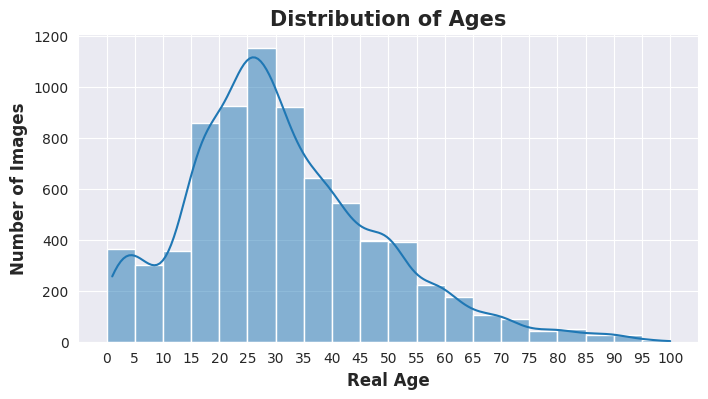

In [9]:
sns.set_style('darkgrid')
plt.figure(figsize = (8,4))

sns.histplot(data = df_labels['real_age'],
             bins = np.arange(0, 101, 5),
             kde = True)

plt.title("Distribution of Ages", fontsize = 15, fontweight = 'bold')
plt.xlabel("Real Age", fontsize = 12, fontweight = 'bold')
plt.ylabel("Number of Images", fontsize = 12, fontweight = 'bold')
plt.xticks(np.arange(0, 101, 5))

plt.show()

In [10]:
# Calculate the percentage of various age ranges
age_below_15 = len(df_labels.query("real_age < 15")) / len(df_labels)
age_15_to_34 = len(df_labels.query("15 <= real_age <= 35")) / len(df_labels)
age_36_to_41 = len(df_labels.query("35 < real_age < 42")) / len(df_labels)
age_above_41 = 1 - age_36_to_41 - age_15_to_34 - age_below_15

age_below_21 = len(df_labels.query("real_age <= 21")) / len(df_labels)
age_above_21 = 1 - age_below_21

print(f"Percentage below the age of 15: {age_below_15:.2%}")
print(f"Percentage between 15 and 35: {age_15_to_34:.2%}")
print(f"Percentage between 35 and 41: {age_36_to_41:.2%}")
print(f"Percentage above the age of 41: {age_above_41:.2%}\n")

print("Drinking Ages (USA):")
print("--------------------")
print(f"Percentage below the age of 21: {age_below_21:.2%}")
print(f"Percentage above the age of 21: {age_above_21:.2%}")

Percentage below the age of 15: 13.42%
Percentage between 15 and 35: 52.68%
Percentage between 35 and 41: 10.04%
Percentage above the age of 41: 23.86%

Drinking Ages (USA):
--------------------
Percentage below the age of 21: 28.94%
Percentage above the age of 21: 71.06%


<span style="font-size: 18px; font-weight: bold;">4.1 Sampled Images for Different Age Groups</span>

,file_name,real_age
1360,001360.jpg,1
6246,006250.jpg,3
1030,001030.jpg,14
1470,001470.jpg,15
912,000912.jpg,17
133,000133.jpg,24
3111,003111.jpg,26
3384,003384.jpg,29
3474,003474.jpg,37
4373,004373.jpg,55


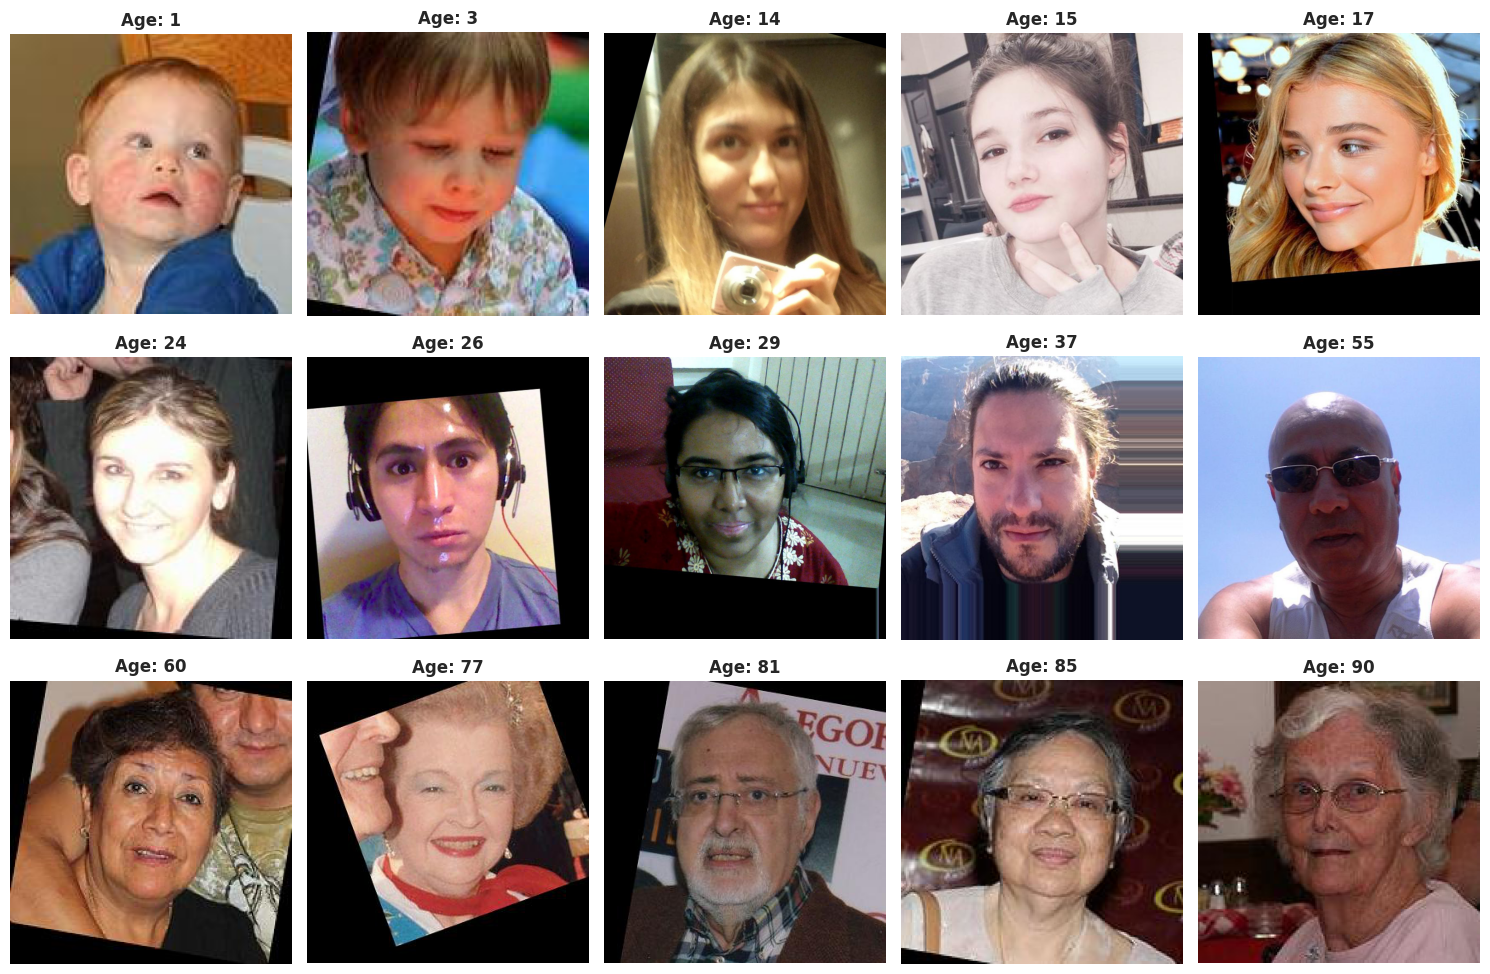

In [11]:
# Group the images by age
# Re-run cell for different images
grouped_ages = df_labels.groupby("real_age").sample(n = 1) 
grouped_ages = grouped_ages.sample(15, random_state = 2).sort_values(by = 'real_age')
display(grouped_ages)

# plot the iamges
plt.figure(figsize = (15, 10))

for i, row in enumerate(grouped_ages.itertuples()):
    if i >= 15:
        break
        
    file_path = os.path.join(image_path, row.file_name)
    image = Image.open(file_path)
    
    plt.subplot(3, 5, i + 1)
    
    plt.imshow(image)
    plt.title(f"Age: {row.real_age}", fontweight = 'bold')
    plt.axis("off")
    
plt.tight_layout()
plt.show()

<span style="font-size: 18px; font-weight: bold;">4.2 Findings</span>

It appears there is a decent mix of individuals across the age groups. For this project, the focus is to develop a model capable of distinguishing individuals **below the drinking age (21 in USA)** from **young adults (22-30)**. Given that slightly over half of the data falls within the 15-35 age range, we should have sufficient data for accurate age verification.

The images exhibit the following characteristics:
- Black and White images.
- Images with different pixel quality.
- Images with varying levels of brightness.
- Some indviduals have face obstructions (usually in younger ages. Ex: Icing, instrument, hats).
- Some images are rotated, slanted, do not fill the entire image boarder.
- Most images are centered and close which may not be realistic for a checkout camera.

These characteristics provide an excellent foundation for developing a robust model. However, additional data augmentation may further improve model performance, particularly in preparing for real-world conditions. We will consider the following augmentations: 
- horizontal flips
- rotation
- zoom

# 5. Modeling
<a id='model'></a>
_______________________________________________________________________________________________________________________________

In [16]:
def load_train(path):
    
    """
    It loads the train part of dataset from the given path.
    """
    
    train_gen = ImageDataGenerator(validation_split = 0.2
                                   ,rescale = 1.0 / 255.0
                                   #,horizontal_flip = True,
                                   #,rotation_range = 20,
                                   #,zoom_range = 0.2
                                   )
    
    df_labels = pd.read_csv(path + 'labels.csv')
    directory = path + 'final_files'
    
    train_gen_flow = train_gen.flow_from_dataframe(
        dataframe = df_labels,
        directory = directory,
        x_col = 'file_name',
        y_col = 'real_age',
        target_size = (150, 150),
        class_mode = 'raw',
        subset = 'training',
        seed = 4321
    )

    return train_gen_flow

In [17]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from the given path.
    """
    
    test_gen = ImageDataGenerator(validation_split = 0.2
                                  ,rescale = 1.0 / 255.0
                                  #,horizontal_flip = True
                                  #,rotation_range = 20
                                  #,zoom_range = 0.2
                                  )
    
    df_labels = pd.read_csv(path + 'labels.csv')
    directory = path + 'final_files'
    
    test_gen_flow = test_gen.flow_from_dataframe(
        dataframe = df_labels,
        directory = directory,
        x_col = 'file_name',
        y_col = 'real_age',
        target_size =  (150, 150),
        class_mode = 'raw',
        subset = 'validation',
        seed = 4321
    )

    return test_gen_flow

In [18]:
def create_model(input_shape):
    
    """
    Returns a defined model.
    """
    
    base = ResNet50(weights = 'imagenet',
                    input_shape = input_shape)
    
    model = Sequential([
        base,
        GlobalAveragePooling2D(),
        #Dropout(0.2),
        Dense(1, activation = 'relu')
    ])
    
    optimizer = Adam(learning_rate = 0.0005)
    
    model.compile(optimizer = optimizer,
                  loss = 'mse',
                  metrics = ['mae'])

    return model

In [19]:
def train_model(model, 
                train_data, 
                test_data, 
                batch_size=None, 
                epochs=20,
                steps_per_epoch=None, 
                validation_steps=None):

    """
    Trains the model given the parameters
    """
    # Calculate steps for training and validation if not provided
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
        
    if validation_steps is None:
        validation_steps = len(test_data)
        
    model.fit(train_data,
              validation_data = test_data,
              batch_size = batch_size,
              epochs = epochs,
              steps_per_epoch = steps_per_epoch,
              valiadtion_steps = validation_steps,
              verbose = 2)
    

    return model

<span style="font-size: 18px; font-weight: bold;">5.1 Prepare the Script to Run on the GPU Platform</span>

The next cell will generate the python script to run on the GPU platform. 

In [20]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

<span style="font-size: 18px; font-weight: bold;">5.2 Output</span>

Epoch 1/20
356/356 - 35s - loss: 95.3532 - mae: 7.4339 - val_loss: 124.3362 - val_mae: 8.4921

Epoch 2/20
356/356 - 35s - loss: 76.8372 - mae: 6.6707 - val_loss: 127.6357 - val_mae: 8.6035

Epoch 3/20
356/356 - 35s - loss: 69.9428 - mae: 6.3992 - val_loss: 91.1531 - val_mae: 7.4454

Epoch 4/20
356/356 - 35s - loss: 64.4249 - mae: 6.1407 - val_loss: 124.0287 - val_mae: 8.3481

Epoch 5/20
356/356 - 35s - loss: 52.8486 - mae: 5.5913 - val_loss: 109.1004 - val_mae: 8.2192

Epoch 6/20
356/356 - 35s - loss: 46.3094 - mae: 5.2223 - val_loss: 85.1038 - val_mae: 7.0332

Epoch 7/20
356/356 - 35s - loss: 38.2617 - mae: 4.7951 - val_loss: 92.0900 - val_mae: 7.3359

Epoch 8/20
356/356 - 35s - loss: 37.4804 - mae: 4.7402 - val_loss: 80.0016 - val_mae: 6.7239

Epoch 9/20
356/356 - 35s - loss: 33.5237 - mae: 4.4271 - val_loss: 83.2579 - val_mae: 6.8529

Epoch 10/20
356/356 - 35s - loss: 28.5170 - mae: 4.1411 - val_loss: 83.5056 - val_mae: 6.9629

Epoch 11/20
356/356 - 35s - loss: 27.0142 - mae: 3.9700 - val_loss: 92.1290 - val_mae: 7.1866

Epoch 12/20
356/356 - 35s - loss: 27.4564 - mae: 4.0428 - val_loss: 185.6307 - val_mae: 11.4591

Epoch 13/20
356/356 - 35s - loss: 23.7961 - mae: 3.7407 - val_loss: 92.3429 - val_mae: 7.2467

Epoch 14/20
356/356 - 35s - loss: 24.6167 - mae: 3.8116 - val_loss: 92.4542 - val_mae: 7.1401

Epoch 15/20
356/356 - 35s - loss: 22.2604 - mae: 3.6746 - val_loss: 82.5822 - val_mae: 6.7841

Epoch 16/20
356/356 - 35s - loss: 20.1899 - mae: 3.4430 - val_loss: 86.3830 - val_mae: 6.8304

Epoch 17/20
356/356 - 35s - loss: 17.3425 - mae: 3.2205 - val_loss: 78.4369 - val_mae: 6.6419

Epoch 18/20
356/356 - 35s - loss: 16.5249 - mae: 3.1295 - val_loss: 81.7731 - val_mae: 6.7226

Epoch 19/20
356/356 - 35s - loss: 16.6140 - mae: 3.1421 - val_loss: 80.9727 - val_mae: 6.9908

Epoch 20/20
356/356 - 35s - loss: 17.0187 - mae: 3.1785 - val_loss: 93.4115 - val_mae: 7.6512

[Back to Contents](#contents)

# 6. General Conclusion
<a id='conclude'></a>
_______________________________________________________________________________________________________________________________

**_Observations:_**
1. The **training loss** and **training MAE** consistently decrease, which indicates the model is learning and improving its predictions over the training data. 

2. The **validation loss** decreases initially (epochs 1-8), which suggests that the model generalizes well in the first 8 epochs. However, starting at epoch 9, the validation loss increases, and at epoch 11 it increases sharply. This indicates **overfitting**, the model is focusing too much on the training data and losing ability to generalize. 

3. The **validation MAE** shows a similar pattern as validation loss - improvement initially and then worsen later in the training process. The lowest MAE is reached at epoch 17 ~ 6.6419, but this is post diminishing returns. 

4. The training metrics improve during training, but the validation metrics plateau and even degrade after a certain point. 

**_Sources of Improvement:_**
- Use of a dropout layer to prevent overfitting by randomly disabling neurons during training. 
- Apply the previously mentioned data augmentations of flips, rotations, and zooms.
- Perhaps adjust the current validation split

[Back to Contents](#contents)